In [1]:
# Add the parent directory to the path so that we can import the modules.
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from market_conditions import *
from dynamic_contagion import *
from reinsurance import *

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Other parameters
maturity = 3
markup = 0.4
R = int(1e5)
seed = 123

# Asset parameters
V_0 = 130
phi_V = -3  # * (1.3) # = V0 / L0
sigma_V = 0.05

# Liability parameters
L_0 = 100
phi_L = -3
sigma_L = 0.02

# Interest rate parameters
r_0 = 0.02
kappa = 0.2
m = 0.05  # 0.5
upsilon = 0.1
lambda_r = -0.01

In [3]:
all_time_series = get_market_conditions(
    R=R,
    seed=seed,
    maturity=maturity,
    kappa=kappa,
    lambda_r=lambda_r,
    m=m,
    phi_V=phi_V,
    sigma_V=sigma_V,
    phi_L=phi_L,
    sigma_L=sigma_L,
    upsilon=upsilon,
    V_0=V_0,
    L_0=L_0,
    r_0=r_0,
)

V_T, L_T, int_r_t = summarise_market_conditions(all_time_series, maturity)

Loading 'c:\Users\Patrick\Dropbox\Jiwook Project Local\catastrophe-reinsurance-pricing-compound-point-process\data\mc-R=100000,seed=123,maturity=3,kappa=0.2,lambda_r=-0.01,m=0.05,phi_V=-3,sigma_V=0.05,phi_L=-3,sigma_L=0.02,upsilon=0.1,V_0=130,L_0=100,r_0=0.02.npy'


100%|██████████| 100000/100000 [00:00<00:00, 214628.80it/s]


In [4]:
assert np.isnan(all_time_series).mean() == 0

In [5]:
# Poisson process
def simulate_poisson(rg):
    lambda_ = 0.5
    return rg.poisson(lambda_ * maturity)


# Cox proces
def simulate_cox(rg):
    lambda0 = 0.49
    a = 0.4
    rho = 0.4
    delta = 1

    selfJumpSizeDist = lambda rg: 0
    extJumpSizeDist = lambda rg: rg.uniform(0, 0.5)

    return simulate_num_dynamic_contagion(
        rg, maturity, lambda0, a, rho, delta, selfJumpSizeDist, extJumpSizeDist
    )


# Hawkes process
def simulate_hawkes(rg):
    lambda0 = 0.47
    a = 0.26
    rho = 0.4
    delta = 1

    selfJumpSizeDist = lambda rg: rg.uniform()
    extJumpSizeDist = lambda rg: 0

    return simulate_num_dynamic_contagion(
        rg, maturity, lambda0, a, rho, delta, selfJumpSizeDist, extJumpSizeDist
    )


# Dynamic contagion process
def simulate_dcp(rg):
    lambda0 = 0.29
    a = 0.26
    rho = 0.4
    delta = 1

    selfJumpSizeDist = lambda rg: rg.uniform()
    extJumpSizeDist = lambda rg: rg.uniform(0, 0.5)

    return simulate_num_dynamic_contagion(
        rg, maturity, lambda0, a, rho, delta, selfJumpSizeDist, extJumpSizeDist
    )

In [6]:
# Catastrophe loss size distribution parameters
mu_C = 2
sigma_C = 0.5

seed = 123
rg = rnd.default_rng(seed)

C_T_poisson, num_cats_poisson = simulate_catastrophe_losses(
    rg, R, simulate_poisson, mu_C, sigma_C
)

C_T_cox, num_cats_cox = simulate_catastrophe_losses(rg, R, simulate_cox, mu_C, sigma_C)

C_T_hawkes, num_cats_hawkes = simulate_catastrophe_losses(
    rg, R, simulate_hawkes, mu_C, sigma_C
)

C_T_dcp, num_cats_dcp = simulate_catastrophe_losses(rg, R, simulate_dcp, mu_C, sigma_C)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [7]:
print(
    f"Average number of catastrophes from Poisson process: {np.mean(num_cats_poisson):.2f}"
)
print(f"Average number of catastrophes from Cox process: {np.mean(num_cats_cox):.2f}")
print(
    f"Average number of catastrophes from Hawkes process: {np.mean(num_cats_hawkes):.2f}"
)
print(
    f"Average number of catastrophes from dynamic contagion process: {np.mean(num_cats_dcp):.2f}"
)

Average number of catastrophes from Poisson process: 1.50
Average number of catastrophes from Cox process: 1.49
Average number of catastrophes from Hawkes process: 1.47
Average number of catastrophes from dynamic contagion process: 1.50


In [8]:
print(
    f"Mean/variance catastrophe loss from Poisson process: {np.mean(C_T_poisson):.2f}, {np.var(C_T_poisson):.2f}"
)
print(
    f"Mean/variance catastrophe loss from Cox process: {np.mean(C_T_cox):.2f}, {np.var(C_T_cox):.2f}"
)
print(
    f"Mean/variance catastrophe loss from Hawkes process: {np.mean(C_T_hawkes):.2f}, {np.var(C_T_hawkes):.2f}"
)
print(
    f"Mean/variance catastrophe loss from dynamic contagion process: {np.mean(C_T_dcp):.2f}, {np.var(C_T_dcp):.2f}"
)

Mean/variance catastrophe loss from Poisson process: 12.54, 134.82
Mean/variance catastrophe loss from Cox process: 12.48, 138.17
Mean/variance catastrophe loss from Hawkes process: 12.33, 266.94
Mean/variance catastrophe loss from dynamic contagion process: 12.53, 270.69


In [9]:
print(
    f"Min/max catastrophe loss from Poisson process: {np.min(C_T_poisson):.2f}, {np.max(C_T_poisson):.2f}"
)
print(
    f"Min/max catastrophe loss from Cox process: {np.min(C_T_cox):.2f}, {np.max(C_T_cox):.2f}"
)
print(
    f"Min/max catastrophe loss from Hawkes process: {np.min(C_T_hawkes):.2f}, {np.max(C_T_hawkes):.2f}"
)
print(
    f"Min/max catastrophe loss from dynamic contagion process: {np.min(C_T_dcp):.2f}, {np.max(C_T_dcp):.2f}"
)

Min/max catastrophe loss from Poisson process: 0.00, 111.82
Min/max catastrophe loss from Cox process: 0.00, 131.92
Min/max catastrophe loss from Hawkes process: 0.00, 238.59
Min/max catastrophe loss from dynamic contagion process: 0.00, 208.32


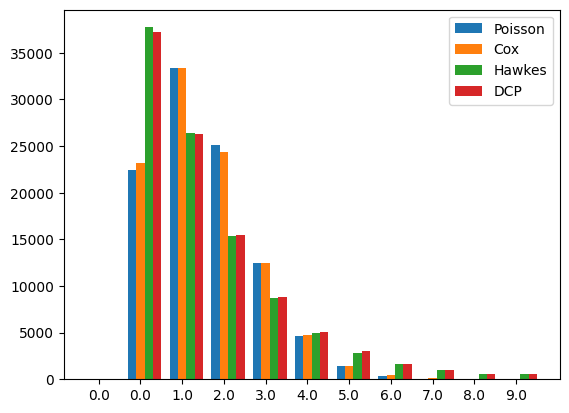

In [10]:
# Plot a grouped vertical bar charts showing the number of simulations which had `n` catastrophes according to each of the arrival processes.
def plot_num_cats(num_cats_poisson, num_cats_cox, num_cats_hawkes, num_cats_dcp):
    num_cats_poisson = np.floor(num_cats_poisson)
    num_cats_cox = np.floor(num_cats_cox)
    num_cats_hawkes = np.floor(num_cats_hawkes)
    num_cats_dcp = np.floor(num_cats_dcp)

    max_cats = np.max(
        [
            np.max(num_cats_poisson),
            np.max(num_cats_cox),
            np.max(num_cats_hawkes),
            np.max(num_cats_dcp),
        ]
    )
    min_cats = np.min(
        [
            np.min(num_cats_poisson),
            np.min(num_cats_cox),
            np.min(num_cats_hawkes),
            np.min(num_cats_dcp),
        ]
    )

    max_cats = min(max_cats, 10)

    num_bins = int(max_cats - min_cats + 1)

    bins = np.linspace(min_cats, max_cats, num_bins + 1)
    bins = np.floor(bins)

    hist_poisson, _ = np.histogram(num_cats_poisson, bins=bins)
    hist_cox, _ = np.histogram(num_cats_cox, bins=bins)
    hist_hawkes, _ = np.histogram(num_cats_hawkes, bins=bins)
    hist_dcp, _ = np.histogram(num_cats_dcp, bins=bins)

    width = 0.2
    x = np.arange(len(bins) - 1)

    plt.bar(x - width, hist_poisson, width, label="Poisson")
    plt.bar(x, hist_cox, width, label="Cox")
    plt.bar(x + width, hist_hawkes, width, label="Hawkes")
    plt.bar(x + 2 * width, hist_dcp, width, label="DCP")

    plt.xticks(x, bins[:-1])
    plt.legend()


plot_num_cats(num_cats_poisson, num_cats_cox, num_cats_hawkes, num_cats_dcp)

In [11]:
prices_poisson = calculate_prices(V_T, L_T, int_r_t, C_T_poisson, markup)
prices_poisson

,M=60,M=65,M=70,M=75,M=80,M=85,M=90
A=10,7.245159,7.252326,7.255910,7.257670,7.258447,7.258779,7.258987
A=15,4.572936,4.580775,4.584705,4.586579,4.587418,4.587768,4.587988
A=20,2.777340,2.785852,2.790128,2.792184,2.793084,2.793457,2.793689
A=25,1.632286,1.641500,1.646136,1.648355,1.649352,1.649753,1.649999
A=30,0.926693,0.936705,0.941683,0.944098,0.945173,0.945630,0.945897


In [12]:
prices_cox = calculate_prices(V_T, L_T, int_r_t, C_T_cox, markup)
prices_cox

,M=60,M=65,M=70,M=75,M=80,M=85,M=90
A=10,7.243868,7.251743,7.255651,7.257533,7.258338,7.258712,7.258886
A=15,4.598286,4.606791,4.610980,4.612986,4.613845,4.614241,4.614424
A=20,2.821773,2.831016,2.835508,2.837667,2.838594,2.839021,2.839216
A=25,1.681876,1.691930,1.696839,1.699148,1.700141,1.700608,1.700822
A=30,0.974720,0.985648,0.990968,0.993456,0.994524,0.995028,0.995268


In [13]:
prices_hawkes = calculate_prices(V_T, L_T, int_r_t, C_T_hawkes, markup)
prices_hawkes

,M=60,M=65,M=70,M=75,M=80,M=85,M=90
A=10,8.024117,8.095024,8.144022,8.178577,8.202993,8.220145,8.232513
A=15,5.843674,5.920697,5.973555,6.010459,6.036543,6.054751,6.067815
A=20,4.234558,4.318534,4.375945,4.415742,4.443561,4.463010,4.476895
A=25,3.040101,3.131666,3.194142,3.237293,3.267321,3.288020,3.302831
A=30,2.153086,2.252192,2.320299,2.367213,2.399757,2.422079,2.437839


In [14]:
prices_dcp = calculate_prices(V_T, L_T, int_r_t, C_T_dcp, markup)
prices_dcp

,M=60,M=65,M=70,M=75,M=80,M=85,M=90
A=10,8.198952,8.270028,8.319298,8.354328,8.379680,8.397446,8.410201
A=15,5.986706,6.064020,6.117095,6.154545,6.181577,6.200466,6.213943
A=20,4.342291,4.426660,4.484366,4.524690,4.553578,4.573695,4.588026
A=25,3.120210,3.212254,3.275192,3.319102,3.350266,3.371752,3.386964
A=30,2.208713,2.308089,2.376650,2.424417,2.458468,2.481665,2.497931
